<a href="https://colab.research.google.com/github/sriharshams/cs498aml/blob/master/homework%201/colab/homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 2: Classification With Support Vector Machines

The UC Irvine machine learning data repository hosts a collection of data on adult income, donated by Ronny Kohavi and Barry Becker. You can find this data at https://archive.ics.uci.edu/ml/datasets/Adult For each record, there is a set of continuous attributes, and a class "less than 50K" or "greater than 50K". We have pre-split the data [training](https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/train.txt) with 43957 examples with known class labels, and [testing](https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test.txt) data with 4885 examples without class labels. Use this data, not the original, for this assignment.

Write a program to train a support vector machine on this data using stochastic gradient descent, as detailed in Procedure 4.3 from the text.

You should not use a package to train the classifier (that's the point), but your own code. You should use **only** the continuous variables as a feature vector. You should scale these variables so that each has unit variance, and you should subtract the mean so that each has zero mean. You should search for an appropriate value of the regularization constant, trying at least the values [1e-3, 1e-2, 1e-1, 1]. Use 10% of your training data as a validation set for this search. You should use at least 50 seasons of at least 300 steps each. In each season, you should separate out 50 training examples at random for evaluation (call this the set held out for the season). You should compute the accuracy of the current classifier on the validation set for the season every 30 steps.

You should produce:

* A plot of the validation accuracy every 30 steps, for each value of the regularization constant.
* A plot of the magnitude of the coefficient vector every 30 steps, for each value of the regularization constant.
* Your estimate of the best value of the regularization constant, together with a brief description of why you believe that is a good value.
* Answer the question: What was your choice for the learning rate and why did you choose it?
* Once you have trained your final classifier, score the provided test set, recording the results in a file with the same format as submission.txt.  You will be able to submit this result to gradescope repeatedly for scoring.

## Set up

Import required libraries

In [0]:
import pandas as pd
import numpy as np
import os
import math
from scipy.stats import norm

import pandas_profiling

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Load dataset

Use the dataset from [training](https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/train.txt)  43957 examples with known class labels for traning and validation set. 

Use the dataset from [testing](https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test.txt) for inference, 4885 examples without class labels.

### Data Set Information:
Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) 

Prediction task is to determine whether a person makes over 50K a year. 

### Attribute Information:
Listing of attributes: 

>50K, <=50K. 

age: continuous. 

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

fnlwgt: continuous. 

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

education-num: continuous. 

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 

sex: Female, Male. 

capital-gain: continuous. 

capital-loss: continuous. 

hours-per-week: continuous. 

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.




To access the dataset in Google Colab you can either use Github or Google Drive. We will be accessing dataset via Google Drive. download  [training](https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/train.txt)  and [testing](https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test.txt)  to a known folder in Google Drive, this folder path in drive will be accessed later to load dataset.


We added the pima-indians-diabetes.csv to Google Drive folder /My Drive/UIUC-MCS-DS/CS498AML/homework_2/data/.

*   Mount Google Drive to access data Note: This is not required if you are not using Google colab

In [0]:
google_colab = True

if google_colab:
  from google.colab import drive
  drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Load training and testing Dataset and save it as a pickle objects

In [0]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',\
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income' ] 
if google_colab:
  gdrive_path = '/content/gdrive/My Drive/UIUC-MCS-DS/CS498AML/homework_2/data/'
else:
  gdrive_path = 'data/'
  
  
if os.path.isfile(gdrive_path+'train.pkl'):
  train_data = pickle.load(open(gdrive_path+'train.pkl', 'rb'))
else:
  train_data = pd.read_csv(gdrive_path+'train.txt', header=None, names= column_names, encoding="utf-8", skipinitialspace=True  )
  pickle.dump(train_data, open( gdrive_path+'train.pkl','wb'))

if os.path.isfile(gdrive_path+'test.pkl'):
  test_data = pickle.load(open(gdrive_path+'test.pkl', 'rb'))
else:
  test_data = pd.read_csv(gdrive_path+'test.txt', header=None, names= column_names[:-1], encoding="utf-8", skipinitialspace=True)
  pickle.dump(test_data, open(gdrive_path+'test.pkl','wb'))

print("shape of training data ", train_data.shape)
print("samples of traning data")
print(train_data.head())

print("shape of testing data ", test_data.shape)
print("samples of testing data")
print(test_data.head())

shape of training data  (43957, 15)
samples of traning data
   age         workclass  fnlwgt  education  education-num  \
0   34           Private  287315    HS-grad              9   
1   43       Federal-gov  145175  Bachelors             13   
2   45         Local-gov   33798    Masters             14   
3   23           Private  180497  Bachelors             13   
4   65  Self-emp-not-inc  145628       10th              6   

       marital-status         occupation   relationship   race     sex  \
0            Divorced  Machine-op-inspct  Not-in-family  White    Male   
1  Married-civ-spouse       Adm-clerical        Husband  White    Male   
2       Never-married     Prof-specialty  Not-in-family  White  Female   
3       Never-married       Tech-support      Own-child  Black  Female   
4  Married-civ-spouse       Craft-repair        Husband  White    Male   

   capital-gain  capital-loss  hours-per-week native-country income  
0             0             0              40  Unite

##  Analyse the labels in training data


income
<=50K    33465
>50K     10492
Name: income, dtype: int64

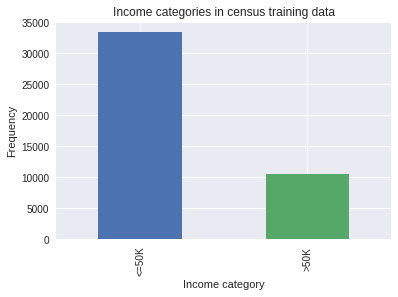

In [0]:
income_labels_plot = pd.value_counts(train_data['income'], sort = True).sort_index()
income_labels_plot.plot(kind = 'bar')
plt.title("Income categories in census training data")
plt.xlabel("Income category")
plt.ylabel("Frequency")

train_data.groupby('income')['income'].count()

Lets look at the training data in details,


In [0]:
# Total number of records in training data
n_records = len(train_data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(train_data[train_data['income']==">50K"])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(train_data[train_data['income']=='<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = ((n_greater_50k*1.0)/n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than 50K: {}".format(n_greater_50k))
print("Individuals making at most 50K: {}".format(n_at_most_50k))
print("Percentage of individuals making more than 50K: {:.2f}%".format(greater_percent))

Total number of records: 43957
Individuals making more than 50K: 10492
Individuals making at most 50K: 33465
Percentage of individuals making more than 50K: 23.87%


- The total number of records,  43957
- The number of individuals making more than 50K annually, 10492.
- The number of individuals making at most 50K annually, 33465.
- The percentage of individuals making more than 50K annually, 23.87%.

## Prepare both test and train data

We will use the prepared data to train, and we ensure same transformation is applied for test data too.

As per the homework interest we are interested in only numerical features, lets identify only numerical features that are requried for data processing of both train and test dataset

Lets identify the type of features in training & test dataset

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
age               43957 non-null int64
workclass         43957 non-null object
fnlwgt            43957 non-null int64
education         43957 non-null object
education-num     43957 non-null int64
marital-status    43957 non-null object
occupation        43957 non-null object
relationship      43957 non-null object
race              43957 non-null object
sex               43957 non-null object
capital-gain      43957 non-null int64
capital-loss      43957 non-null int64
hours-per-week    43957 non-null int64
native-country    43957 non-null object
income            43957 non-null object
dtypes: int64(6), object(9)
memory usage: 5.0+ MB


In [0]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4885 entries, 0 to 4884
Data columns (total 14 columns):
age               4885 non-null int64
workclass         4885 non-null object
fnlwgt            4885 non-null int64
education         4885 non-null object
education-num     4885 non-null int64
marital-status    4885 non-null object
occupation        4885 non-null object
relationship      4885 non-null object
race              4885 non-null object
sex               4885 non-null object
capital-gain      4885 non-null int64
capital-loss      4885 non-null int64
hours-per-week    4885 non-null int64
native-country    4885 non-null object
dtypes: int64(6), object(8)
memory usage: 534.4+ KB


In [0]:
numerical_cols = train_data.select_dtypes(exclude=['object']).columns
print(numerical_cols)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


We will analyse and transform only 6 numerical features.

In [0]:
# Encode the 'income' data to numerical values
training_label_raw = train_data['income']
training_label = training_label_raw.apply(lambda x: -1 if x == "<=50K" else 1)
training_label.columns = 'income'
print(pd.value_counts(training_label.values, sort=False))

 1    10492
-1    33465
dtype: int64


In [0]:
training_numerical_data = train_data[numerical_cols]
print("training dataset shape ", training_numerical_data.shape )
testing_numerical_data = test_data[numerical_cols]
print("testing dataset shape ", testing_numerical_data.shape )

training dataset shape  (43957, 6)
testing dataset shape  (4885, 6)


##### Profile training and tesiting data

In [0]:
training_numerical_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,43957.000000,4.395700e+04,43957.000000,43957.000000,43957.000000,43957.000000
mean,38.635121,1.897506e+05,10.078531,1088.224538,86.624337,40.413768
std,13.709061,1.059574e+05,2.566403,7548.199742,400.228624,12.326645
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175670e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779740e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376300e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [0]:
print("training data, ",training_numerical_data.isnull().sum())


training data,  age               0
fnlwgt            0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
dtype: int64


In [0]:
print("testing data, ", testing_numerical_data.isnull().sum())


testing data,  age               0
fnlwgt            0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
dtype: int64


In [0]:
print("labels data, ", training_label[27204])

labels data,  1


pandas_profiling.ProfileReport(training_numerical_data)

##### Transforming Skewed Continuous Features

According to data distribution looks like 
capital-gain has 40369 / 91.8% zeros Zeros
capital-loss has 41918 / 95.4% zeros Zeros

Lets analyze capital-gain, capital-loss in more detail.

In [0]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################


import matplotlib.patches as mpatches

def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

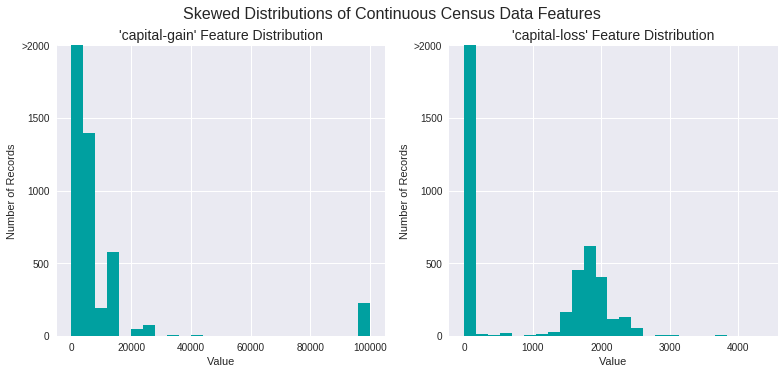

In [0]:
# Visualize skewed continuous features of training data
distribution(training_numerical_data)

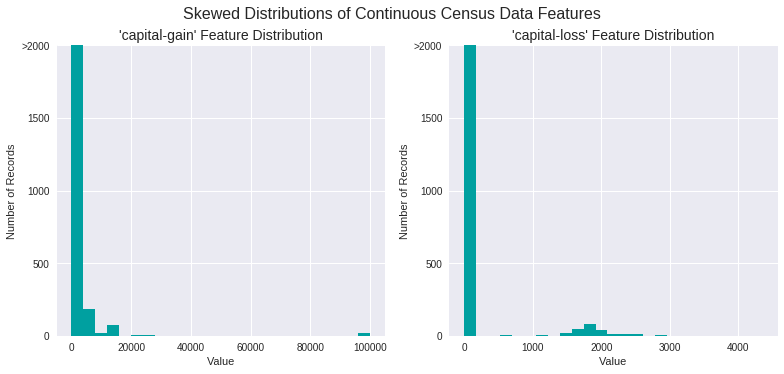

In [0]:
# Visualize skewed continuous features of testing data
distribution(testing_numerical_data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

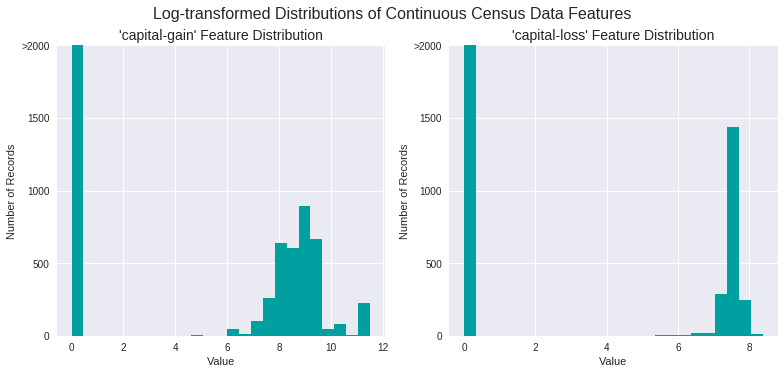

In [0]:
# Log-transform the skewed features of traning data
skewed = ['capital-gain', 'capital-loss']
training_numerical_data[skewed] = training_numerical_data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
distribution(training_numerical_data, transformed = True)

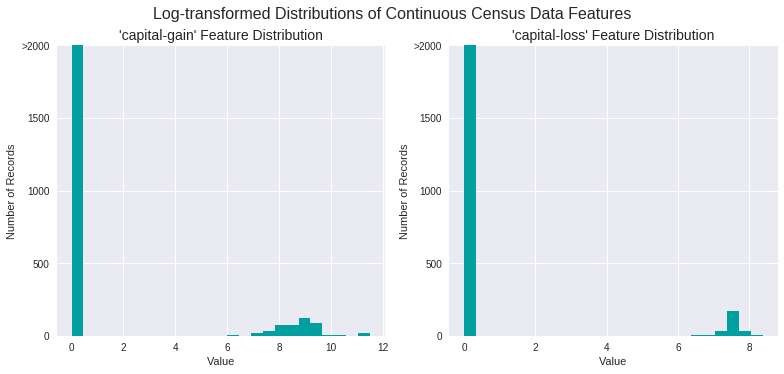

In [0]:
#Log-transform the skewed features of testing data
testing_numerical_data[skewed] = testing_numerical_data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
distribution(testing_numerical_data, transformed = True)

##### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning,.

scale these variables so that each has unit variance, and you should subtract the mean so that each has zero mean. 

In [0]:
def custom_scale(features):
  for col in range(features.shape[1]):
    feature_column = features[:,col]
    features[:,col] = (feature_column - feature_column.mean()) / feature_column.std()
  return features

training_numerical_scaled_data = custom_scale(training_numerical_data.values)
print(training_numerical_scaled_data[0])
testing_numerical_scaled_data = custom_scale(testing_numerical_data.values)
print(testing_numerical_scaled_data[0])

[-0.3381102   0.92079942 -0.42025492 -0.29595765 -0.22042683 -0.03356734]
[-0.19818512 -0.60877221 -0.02837371 -0.31521386 -0.22868823 -0.03857327]


## Split data
Reuse the homework 1 code, changed the order of return variables

In [0]:

def train_test_split(features, labels, test_size=0.2, random_state=0):
  """
  split the features and lables radomly based on test_size
  """
  np.random.seed(random_state)
  id = np.random.rand(len(features))>test_size
  #print(id)
  features_train = features[id]
  labels_train = labels[id]
  features_test = features[np.invert(id)]
  labels_test = labels[np.invert(id)]
  return features_train,features_test, labels_train, labels_test



1.   Split the data to find the best accuracy train / test split of test split size 10%
2.   From Step 1, trainng set split the data into train / test, test split of size 10% for searching regularization constant Lambda
3.   From Step 2, traning set split the data into train / test, test split of size 10% for identifying the right steplength or learning rate


In [0]:
X_train, X_test, y_train, y_test = train_test_split( \
                                                    np.array(training_numerical_scaled_data), \
                                                    np.array(training_label), test_size=0.1, \
                                                    random_state=0)
X_train_lambda, X_test_lambda, y_train_lambda, y_test_lambda = train_test_split(X_train, y_train,\
                                                                             test_size=0.1, random_state=0)

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_train_lambda, y_train_lambda, \
                                                               test_size=0.1, random_state=0)


## Classify

Support vector machine using stochastic gradient descent





In [0]:
from sklearn.metrics import accuracy_score

class Svm_sgd(object):
  """" Svm classifier using stochastic gradient descent"""

  def __init__(self, input_dim, output_dim, random_state=0):
      self.a = None
      
      # try random initialization
      self.a = np.zeros(input_dim,)
      self.b = np.zeros(output_dim,)[0]
      

  def calculate_cost_gradients(self, x, y, C):
      """
      Svm cost function
      f: Input dimension of feature vector.
      class_label: Number of Classes.
      N: Number of example.
      Inputs:
      - x: A numpy array of shape (batch_size, f).
      - y: A numpy array of shape (N,) where value < class_label.
      - reg: (float) regularization strength.
      Returns a tuple of:
      - loss as single float.
      - gradient with respect to weights self.a (da) with the same shape of self.a.
      """
      cost = 0.0
      da = np.zeros_like(self.a)
      m = x.shape[0]

      # - Compute the svm loss and store to loss variable.                        #
      # - Compute gradient and store to da variable.                              #
      # - Use L2 regularization   

      #γi = aT xi + b

      #Calculating γi matrix
      gamma = np.dot(x, self.a.T) + self.b
      
      hinge = gamma * y
      
      pos_hing = np.where(hinge >= 1)
      neg_hing = np.where(hinge < 1)
      
      # da = { λa if yk(aTxk + b)≥ 1
      posda =  ( C * self.a)
      
      # da = { λa − ykx otherwise
      negda = (( C * self.a) - (np.sum(y[neg_hing] * x[neg_hing].T, axis=1)))
      da =  (posda + negda)
      
      # db = {0 if yk(aTxk + b)≥ 1
			#      {−yk otherwise
       
      db = - (np.sum(y[neg_hing]))
      
      
      #S(a, b; λ) = [(1/N)  NEi=1 max(0, 1 − yi (aT xi + b)] + λ aT.a /2
      
      cost = (1/m * np.sum(np.maximum(0,1 - hinge))) + (C * np.dot(self.a.T, self.a) / 2)
      
      cost = np.squeeze(cost)
      
      return cost, da, db

  def train(self, x_train, y_train, reg=1e-5, seasons=50, steps=300, eval_steps=30, verbose=False, mn=(1, 50)):
      """
      Train this Svm classifier using stochastic gradient descent.
      f: Input dimension of feature vector.
      class_label: Number of Classes.
      N: Number of example.
      Inputs:
      - x_train: A numpy array of shape (batchSize, f).
      - y_train: A numpy array of shape (N,) where value < class_label.
      - lr: (float) learning rate for optimization.
      - reg: (float) regularization strength.
      - iter: (integer) total number of iterations.
      - batchSize: (integer) number of example in each batch running.
      - verbose: (boolean) Print log of loss and training accuracy.
      Outputs:
      A list containing the value of the loss at each training iteration.
      """

      # Run stochastic gradient descent to optimize W.
      m,n = mn
      cost_history = []
      heldout_set_accuracies = []
      a_mag = []
      steplength = 0
      index_array = np.array(range(len(x_train)))
      cur_step = 0
      for season in range(seasons):
          """
          You should use at least 50 seasons of at least 300 steps each. I
          n each season, you should separate out 50 training examples at random 
          for evaluation (call this the set held out for the season). 
          You should compute the accuracy of the current classifier on 
          the held out set for the season every 30 steps.
          """
          # to test different learning rate
          # 0.01
          steplength= m/ ((0.01 * season)+ n)
              
          mask = np.array(range(0,len(y_train)))
          np.random.shuffle(mask)
          x_season_eval = np.array(x_train[mask[-50:]])
          y_season_eval = np.array(y_train[mask[-50:]])
          index_array = np.array_split(mask[:-50], steps)
          
          
          for step in range(steps):
            batch_size = len(index_array[step])
            x_season_train_batch = x_train[index_array[step]]
            y_season_train_batch = y_train[index_array[step]] #.reshape(batch_size, 1)
            
            cost, da, db= self.calculate_cost_gradients(x_season_train_batch,y_season_train_batch,reg)
            
            if cur_step % eval_steps == 0:
                y_season_pred = self.predict(x_season_eval)
                eval_score = self.calculate_accuracy(y_season_eval, y_season_pred)
                heldout_set_accuracies.append(eval_score)
                a_mag.append(np.dot(self.a.T, self.a))
                cost_history.append(cost)
                
                if verbose:
                  print ('Loop {0} cost {1}'.format(step, cost))
                         
            self.a -= steplength * da
            self.b -= steplength * db
            cur_step += 1
            
      return heldout_set_accuracies, a_mag, cost_history

  
  def predict(self, x,):
    """
    Predict the y output.
    Inputs:
    - x: training data of shape (N, f)
    Returns:
    - y_pred: output data of shape (N, ) where value < class_label
    """
    # -  Store the predict output in y_pred                                    #

    s = x.dot(self.a)+self.b
    y_pred = np.array([1 if pred > 0 else -1 for pred in s])
    return y_pred


  def calculate_accuracy(self, y_epoch_test, y_pred_test):
    return accuracy_score(y_epoch_test, y_pred_test)


## Choosing a steplength (Learning rate):

As per http://luthuli.cs.uiuc.edu/~daf/courses/AML-18-Fall/AMLbook-3-Dec-18.pdf section 4.1.3, choose steplenght as funcation of season, i.e steplength = m/( 0.01*season + n ), tried different combination of m,n = (10000, 50) (100, 50) (1, 50)(1, 5000) (1, 500000)


In [0]:
m_ns = [(10000, 50), (100, 50), (1, 50), (1, 500), (1, 5000)]

heldout_set_lr_accuracies = {}
cost_lr_histories = {}
a_mags_lr = {}
best_accuracy_lr = 0
best_lr= None

for m_n in m_ns:
    svm_lr = Svm_sgd(X_train_lr.shape[1], 1)
    
    heldout_set_lr_accuracy, a_mag_lr, cost_lr_history = svm_lr.train(X_train_lr, y_train_lr, reg=0.1, seasons=50, steps=300, eval_steps=30, verbose=False, mn=m_n)
    y_pred_lr = svm_lr.predict(X_test_lr)
    accuracy_lr = svm_lr.calculate_accuracy(y_test_lr, y_pred_lr)
    print(f"steplength season multiplier {m_n}, accuracy {accuracy_lr}")
    if accuracy_lr > best_accuracy_lr:
        best_accuracy_lr = accuracy_lr
        best_lr = m_n
    
    heldout_set_lr_accuracies[str(m_n)] = heldout_set_lr_accuracy
    cost_lr_histories[str(m_n)] = cost_lr_history
    a_mags_lr[str(m_n)] = a_mag_lr

steplength season multiplier (10000, 50), accuracy 0.7516447368421053
steplength season multiplier (100, 50), accuracy 0.7623355263157895
steplength season multiplier (1, 50), accuracy 0.78125
steplength season multiplier (1, 500), accuracy 0.7735745614035088
steplength season multiplier (1, 5000), accuracy 0.7697368421052632


In [0]:
print(best_lr)

(1, 50)


## Search regularizer

Search regularizer and identify the best regularizer based on accuracy matric. Searching different regularizer, found 1.0 as the nest regularizer for this dataset

In [0]:
regularizers = [1e-4, 1e-3, 1e-2, 1e-1, 1]

heldout_set_accuracies = {}
cost_histories = {}
a_mags = {}
best_accuracy = 0
best_regularizer= None



for C in regularizers:
    svm = Svm_sgd(X_train_lambda.shape[1], 1)
    
    heldout_set_accuracy, a_mag, cost_history = svm.train(X_train_lambda, y_train_lambda, reg=C, seasons=50, steps=300, eval_steps=30, verbose=False, mn=best_lr)
    y_pred_lambda = svm.predict(X_test_lambda)
    accuracy = svm.calculate_accuracy(y_test_lambda, y_pred_lambda)
    print(f"regularizer {C}, accuracy {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_regularizer = C
    
    heldout_set_accuracies[str(C)] = heldout_set_accuracy
    cost_histories[str(C)] = cost_history
    a_mags[str(C)] = a_mag



regularizer 0.0001, accuracy 0.8072348860257681
regularizer 0.001, accuracy 0.7869177403369673
regularizer 0.01, accuracy 0.790386521308226
regularizer 0.1, accuracy 0.7953419226957383
regularizer 1, accuracy 0.7926164519326065


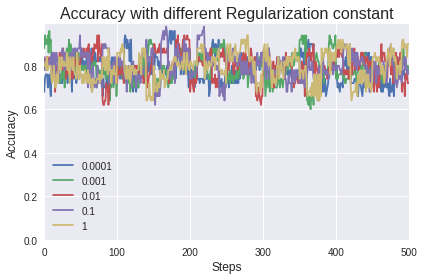

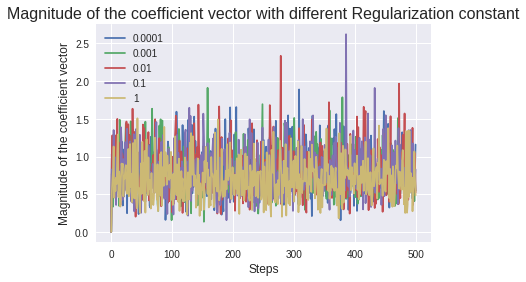

In [0]:
fig = plt.figure(figsize = (6,4))

for name, data in heldout_set_accuracies.items():
    plt.plot(data, label=name)
plt.title("Accuracy with different Regularization constant", fontsize = 16)
plt.ylim((0.00, 0.99))
plt.xlim((0, 500))
plt.ylabel("Accuracy", fontsize = 12)
plt.xlabel("Steps", fontsize = 12)
plt.legend()
plt.tight_layout()
plt.show()  


fig = plt.figure(figsize = (6,4))
for name, data in a_mags.items():
    plt.plot(data, label=name)
plt.title('Magnitude of the coefficient vector with different Regularization constant', fontsize = 16)
plt.xlabel('Steps', fontsize = 12)
plt.ylabel('Magnitude of the coefficient vector', fontsize = 12)
plt.legend()
plt.show()

## Prediction for unknown label testset

Lets use the best regularizer C=0.01 and steplength = 1.0/ (1.0* season + 50), and train on all knonw training set to generate the prediction to be submitted for gradescope.

In [0]:
import datetime

svm_final = Svm_sgd(X_train.shape[1], 1)

final_heldout_set_accuracy, final_a_mag, final_cost_history = svm_final.train(X_train, y_train, reg=best_regularizer, seasons=50, steps=300, eval_steps=30, verbose=False, mn=best_lr)
y_pred = svm_final.predict(X_test)
accuracy_final = svm_final.calculate_accuracy(y_test, y_pred)
print(f"final accuracy {accuracy_final}")



final accuracy 0.8044296788482835


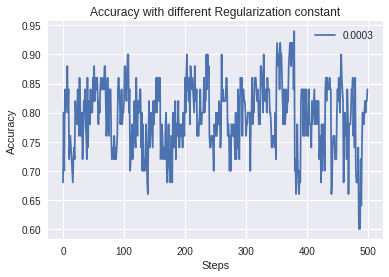

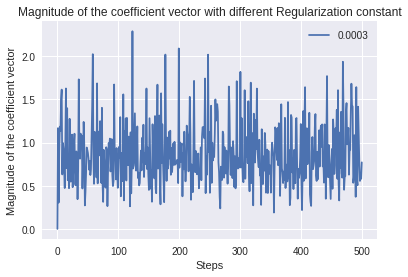

In [0]:
plt.plot(final_heldout_set_accuracy, label='0.0003')
plt.title('Accuracy with different Regularization constant')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(final_a_mag, label='0.0003')
plt.title('Magnitude of the coefficient vector with different Regularization constant')
plt.xlabel('Steps')
plt.ylabel('Magnitude of the coefficient vector')
plt.legend()
plt.show()

In [0]:
import time
import datetime

os.environ['TZ'] = "US/Pacific"
time.tzset()
ts = time.localtime()
st = time.strftime('%Y-%m-%d %H:%M:%S', ts)

submission_pred = svm_final.predict(testing_numerical_scaled_data)

submission_df = pd.DataFrame(data={'income': submission_pred})

#print(submission_df)

def conver_income(pred):
    if pred >= 0:
        return'>50K'
    else:
        return '<=50K'


submission_df['income'] = submission_df['income'].apply(conver_income)
submission_df.to_csv('/content/gdrive/My Drive/UIUC-MCS-DS/CS498AML/homework_2/data/submission'+st+'.txt', header=False, index=False)


In [0]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=300, n_iter=50)

clf.fit(X_train, y_train)

print(f"score {clf.score(X_test, y_test)}")



score 0.8057585825027685


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


## References

http://luthuli.cs.uiuc.edu/~daf/courses/AML-18-Fall/AMLbook-3-Dec-18.pdf 

https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

https://pythonprogramming.net/svm-optimization-python-2-machine-learning-tutorial/?completed=/svm-optimization-python-machine-learning-tutorial/

https://medium.com/deep-math-machine-learning-ai/chapter-3-1-svm-from-scratch-in-python-86f93f853dc

https://pythonprogramming.net/svm-in-python-machine-learning-tutorial/

https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/

http://tullo.ch/articles/svm-py/

https://www.kdnuggets.com/2017/02/learned-implementing-classifier-scratch-python.html

https://towardsdatascience.com/a-complete-machine-learning-project-walk-through-in-python-part-two-300f1f8147e2

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-6/

https://github.com/adityajn105/SVM-From-Scratch

https://github.com/sriharshams

https://www.svm-tutorial.com/svm-tutorial/math-svm-tutorial/
